In [1]:
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Input, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
data_path = "/kaggle/input/scaled/btc_scaled_features.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
btc_full = pd.read_csv("/kaggle/input/full-features/btc_features_full.csv", index_col=0, parse_dates=True)

In [4]:
feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'sma_7', 'sma_21', 'ema_7', 'ema_21',
    'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff',
    'dayofweek', 'month', 'is_weekend'
]
target_col = 'close'

In [5]:
def create_sequences(data, target_col_idx, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i][target_col_idx])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
X, y = create_sequences(scaled, feature_cols.index(target_col), sequence_length=60)

In [6]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+val_size:]

In [7]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [8]:
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0101 - val_loss: 7.9130e-04
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1628e-04 - val_loss: 4.4044e-04
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6039e-04 - val_loss: 4.8535e-04
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9860e-04 - val_loss: 4.1888e-04
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7937e-04 - val_loss: 2.7411e-04
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7079e-04 - val_loss: 3.4653e-04
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6767e-04 - val_loss: 2.5682e-04
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2281e-04 - val_loss: 5.9905e-04
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5697e-04 - val_loss: 1.7724e-04
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5463e-05 - val_loss: 1.5580e-04
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0149e-04 - 

In [9]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MSE: 0.0010622492932721524


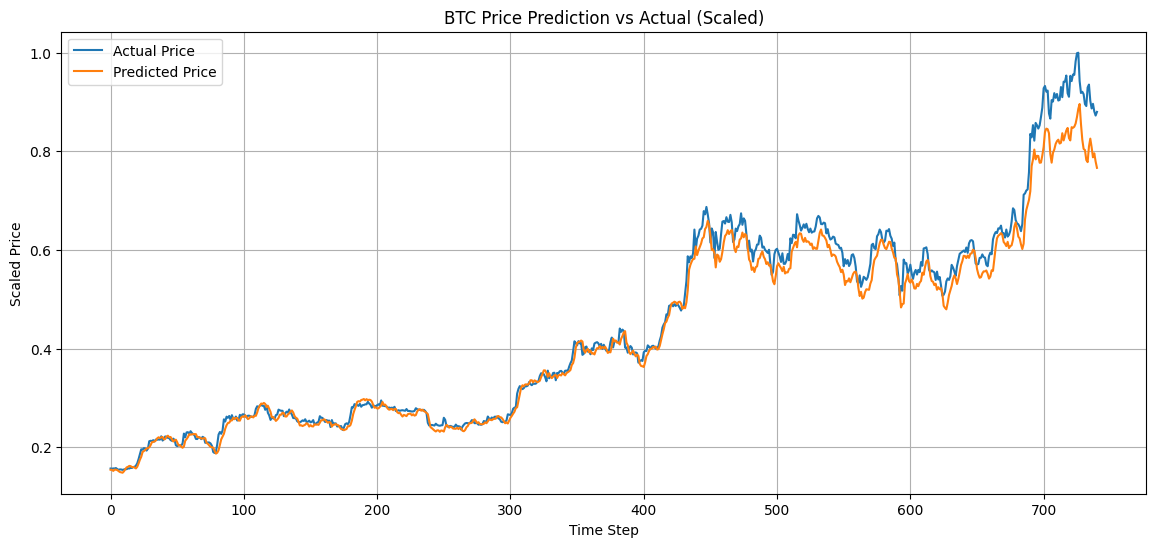

In [10]:
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title("BTC Price Prediction vs Actual (Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Price")
plt.legend()
plt.grid(True)
# plt.savefig('/kaggle/working/plot.png')
plt.show()

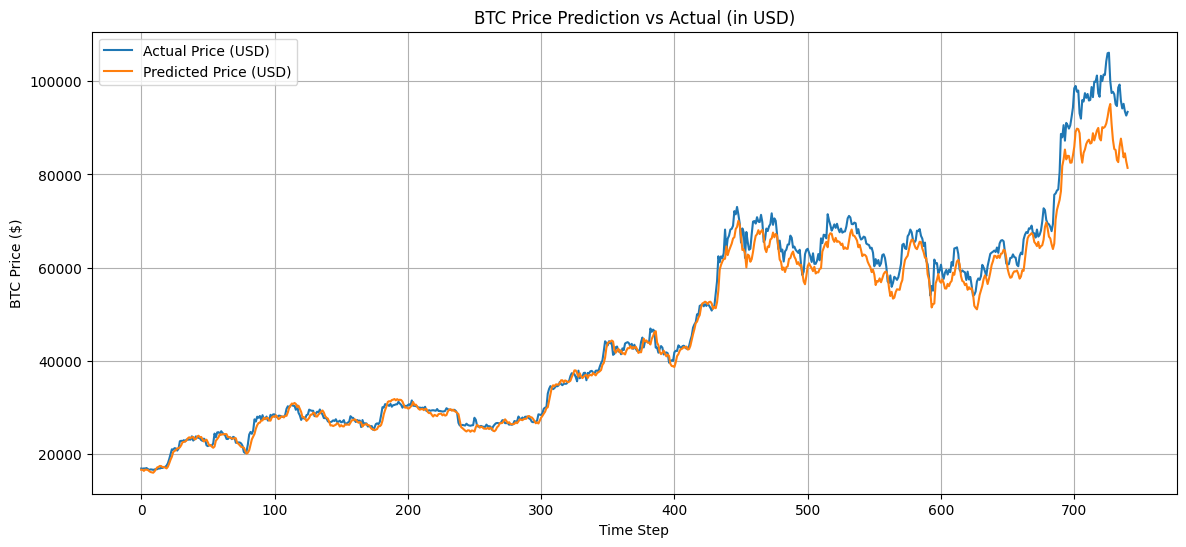

In [11]:
btc_model = btc_full[feature_cols].copy()
scaler = MinMaxScaler()
scaler.fit(btc_model)

y_test_full = np.zeros((len(y_test), len(feature_cols)))
y_test_full[:, feature_cols.index("close")] = y_test.flatten()

y_pred_full = np.zeros((len(y_pred), len(feature_cols)))
y_pred_full[:, feature_cols.index("close")] = y_pred.flatten()

y_test_real = scaler.inverse_transform(y_test_full)[:, feature_cols.index("close")]
y_pred_real = scaler.inverse_transform(y_pred_full)[:, feature_cols.index("close")]

plt.figure(figsize=(14,6))
plt.plot(y_test_real, label='Actual Price (USD)')
plt.plot(y_pred_real, label='Predicted Price (USD)')
plt.title("BTC Price Prediction vs Actual (in USD)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price ($)")
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/plot.png')
plt.show()

In [12]:
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)
corr, _ = pearsonr(y_test_real, y_pred_real)

print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation: {corr:.4f}")

Mean Absolute Error (MAE): $2154.62
Root Mean Squared Error (RMSE): $3453.55
R² Score: 0.9749
Pearson Correlation: 0.9958


In [13]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')


In [14]:
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0126 - val_loss: 6.9099e-04
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 2.2533e-04
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7751e-04 - val_loss: 2.0691e-04
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2299e-04 - val_loss: 4.1126e-04
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0274e-04 - val_loss: 2.6610e-04
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0203e-04 - val_loss: 3.1407e-04


In [15]:
y_pred_gru = gru_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gru)
print("Test MSE:", mse)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE: 0.0005609578508444004


In [16]:
def inverse_scale_predictions(y_scaled, scaler, target_index):
    y_full = np.zeros((len(y_scaled), len(feature_cols)))
    y_full[:, target_index] = y_scaled.flatten()
    return scaler.inverse_transform(y_full)[:, target_index]

y_pred_gru_real = inverse_scale_predictions(y_pred_gru, scaler, feature_cols.index(target_col))


In [17]:
mae_gru = mean_absolute_error(y_test_real, y_pred_gru_real)
rmse_gru = np.sqrt(mean_squared_error(y_test_real, y_pred_gru_real))
r2_gru = r2_score(y_test_real, y_pred_gru_real)
corr_gru, _ = pearsonr(y_test_real, y_pred_gru_real)

print("GRU MAE (USD):", mae_gru)
print("GRU RMSE (USD):", rmse_gru)
print("GRU R² Score:", r2_gru)
print("GRU Pearson Corr:", corr_gru)


GRU MAE (USD): 1635.5968537997567
GRU RMSE (USD): 2509.673965977719
GRU R² Score: 0.9867542888014494
GRU Pearson Corr: 0.9956043295113505


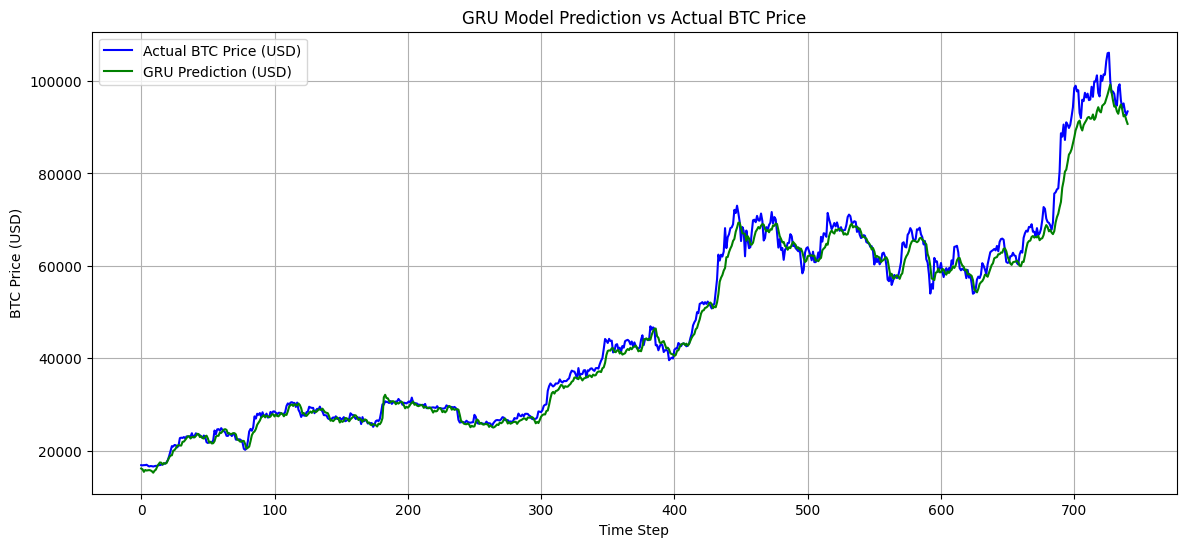

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_real, label='Actual BTC Price (USD)', color='blue')
plt.plot(y_pred_gru_real, label='GRU Prediction (USD)', color='green')
plt.title("GRU Model Prediction vs Actual BTC Price")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout
plt.savefig('/kaggle/working/plot1.png')
plt.show()

Ensemble MAE (USD): 1788.5160939469035
Ensemble RMSE (USD): 2812.0424405036174
Ensemble R² Score: 0.9833703000805946
Ensemble Pearson Corr: 0.9965797349300157


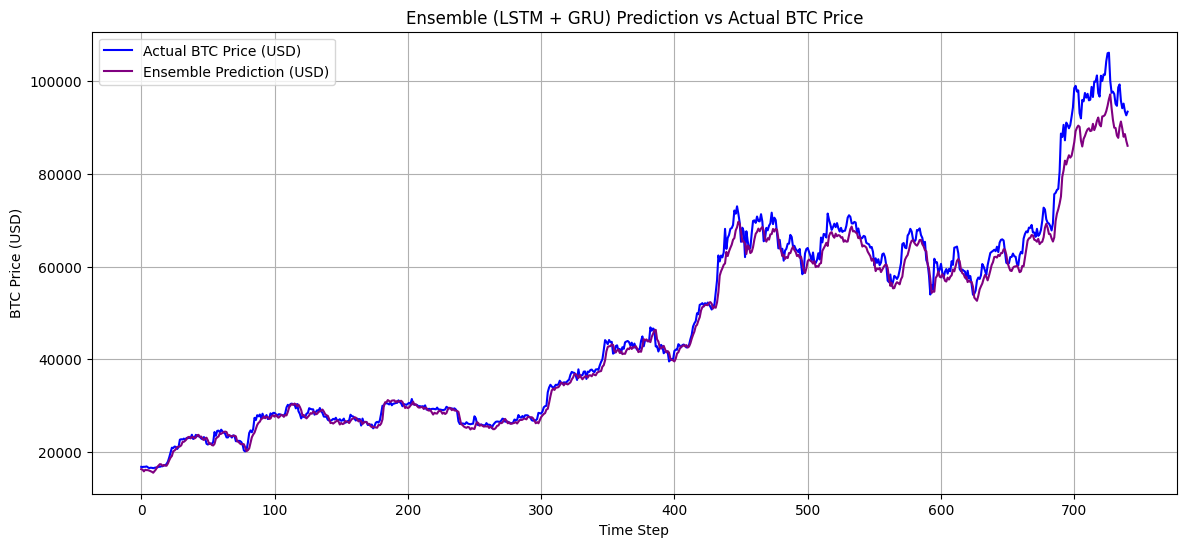

In [19]:
y_pred_ensemble_real = (y_pred_real + y_pred_gru_real) / 2

mae_ens = mean_absolute_error(y_test_real, y_pred_ensemble_real)
rmse_ens = np.sqrt(mean_squared_error(y_test_real, y_pred_ensemble_real))
r2_ens = r2_score(y_test_real, y_pred_ensemble_real)
corr_ens, _ = pearsonr(y_test_real, y_pred_ensemble_real)

print("Ensemble MAE (USD):", mae_ens)
print("Ensemble RMSE (USD):", rmse_ens)
print("Ensemble R² Score:", r2_ens)
print("Ensemble Pearson Corr:", corr_ens)

plt.figure(figsize=(14, 6))
plt.plot(y_test_real, label='Actual BTC Price (USD)', color='blue')
plt.plot(y_pred_ensemble_real, label='Ensemble Prediction (USD)', color='purple')
plt.title("Ensemble (LSTM + GRU) Prediction vs Actual BTC Price")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout
plt.savefig('/kaggle/working/plot2.png')
plt.show()
